# Preparation

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# change working diretory
# import os
# os.chdir("/content/gdrive/MyDrive/Dissertation/")

Mounted at /content/gdrive


In [2]:
!ls runs/detect
# %cd drive/MyDrive/Dissertation

ls: cannot access 'runs/detect': No such file or directory


Make sure GPU work fine.

In [3]:
!nvidia-smi

Wed Aug  2 15:21:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Make sure we are in the right working directory.

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


Install YOLOv8.

In [5]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 25.5 GB RAM, 24.4/166.8 GB disk)


In [6]:
from ultralytics import YOLO

from IPython.display import display, Image

# Train on the original dataset

### Download the dataset
Train:Val:Test = 7:2:1

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="lOVTQ88BgSlHqrup7AYi")
project = rf.workspace("dissertation-bqltf").project("minneapple-qo6jh")
dataset = project.version(1).download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.20, to fix: `pip install ultralytics==8.0.134`


Extracting Dataset Version Zip to MinneApple-1 in yolov8:: 100%|██████████| 2014/2014 [00:00<00:00, 2738.81it/s]


## Train the model

The training ends at 149th epoch as no improvement.

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=300 imgsz=720 plots=True  # 300


/content
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/MinneApple-1/data.yaml, epochs=300, patience=50, batch=16, imgsz=720, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=F

In [ ]:
!ls {HOME}/runs/detect/train6/  # check the model is prodeced

args.yaml					     train_batch0.jpg
events.out.tfevents.1690932696.8043ed8c498b.25075.0  train_batch1.jpg
results.csv					     train_batch2.jpg
results.png					     weights


In [ ]:
%cp {HOME}/runs/detect/train6/weights/best.pt /content/gdrive/My\ Drive/Dissertation/Models  # save the model
%cp {HOME}/runs/detect/train6/results.png /content/gdrive/My\ Drive/Dissertation/Models  # save the training result plots


From the metrics/mAP50(B) and metrics/mAP50-95(B), we can see the model converges at around 100th epoch.

/content


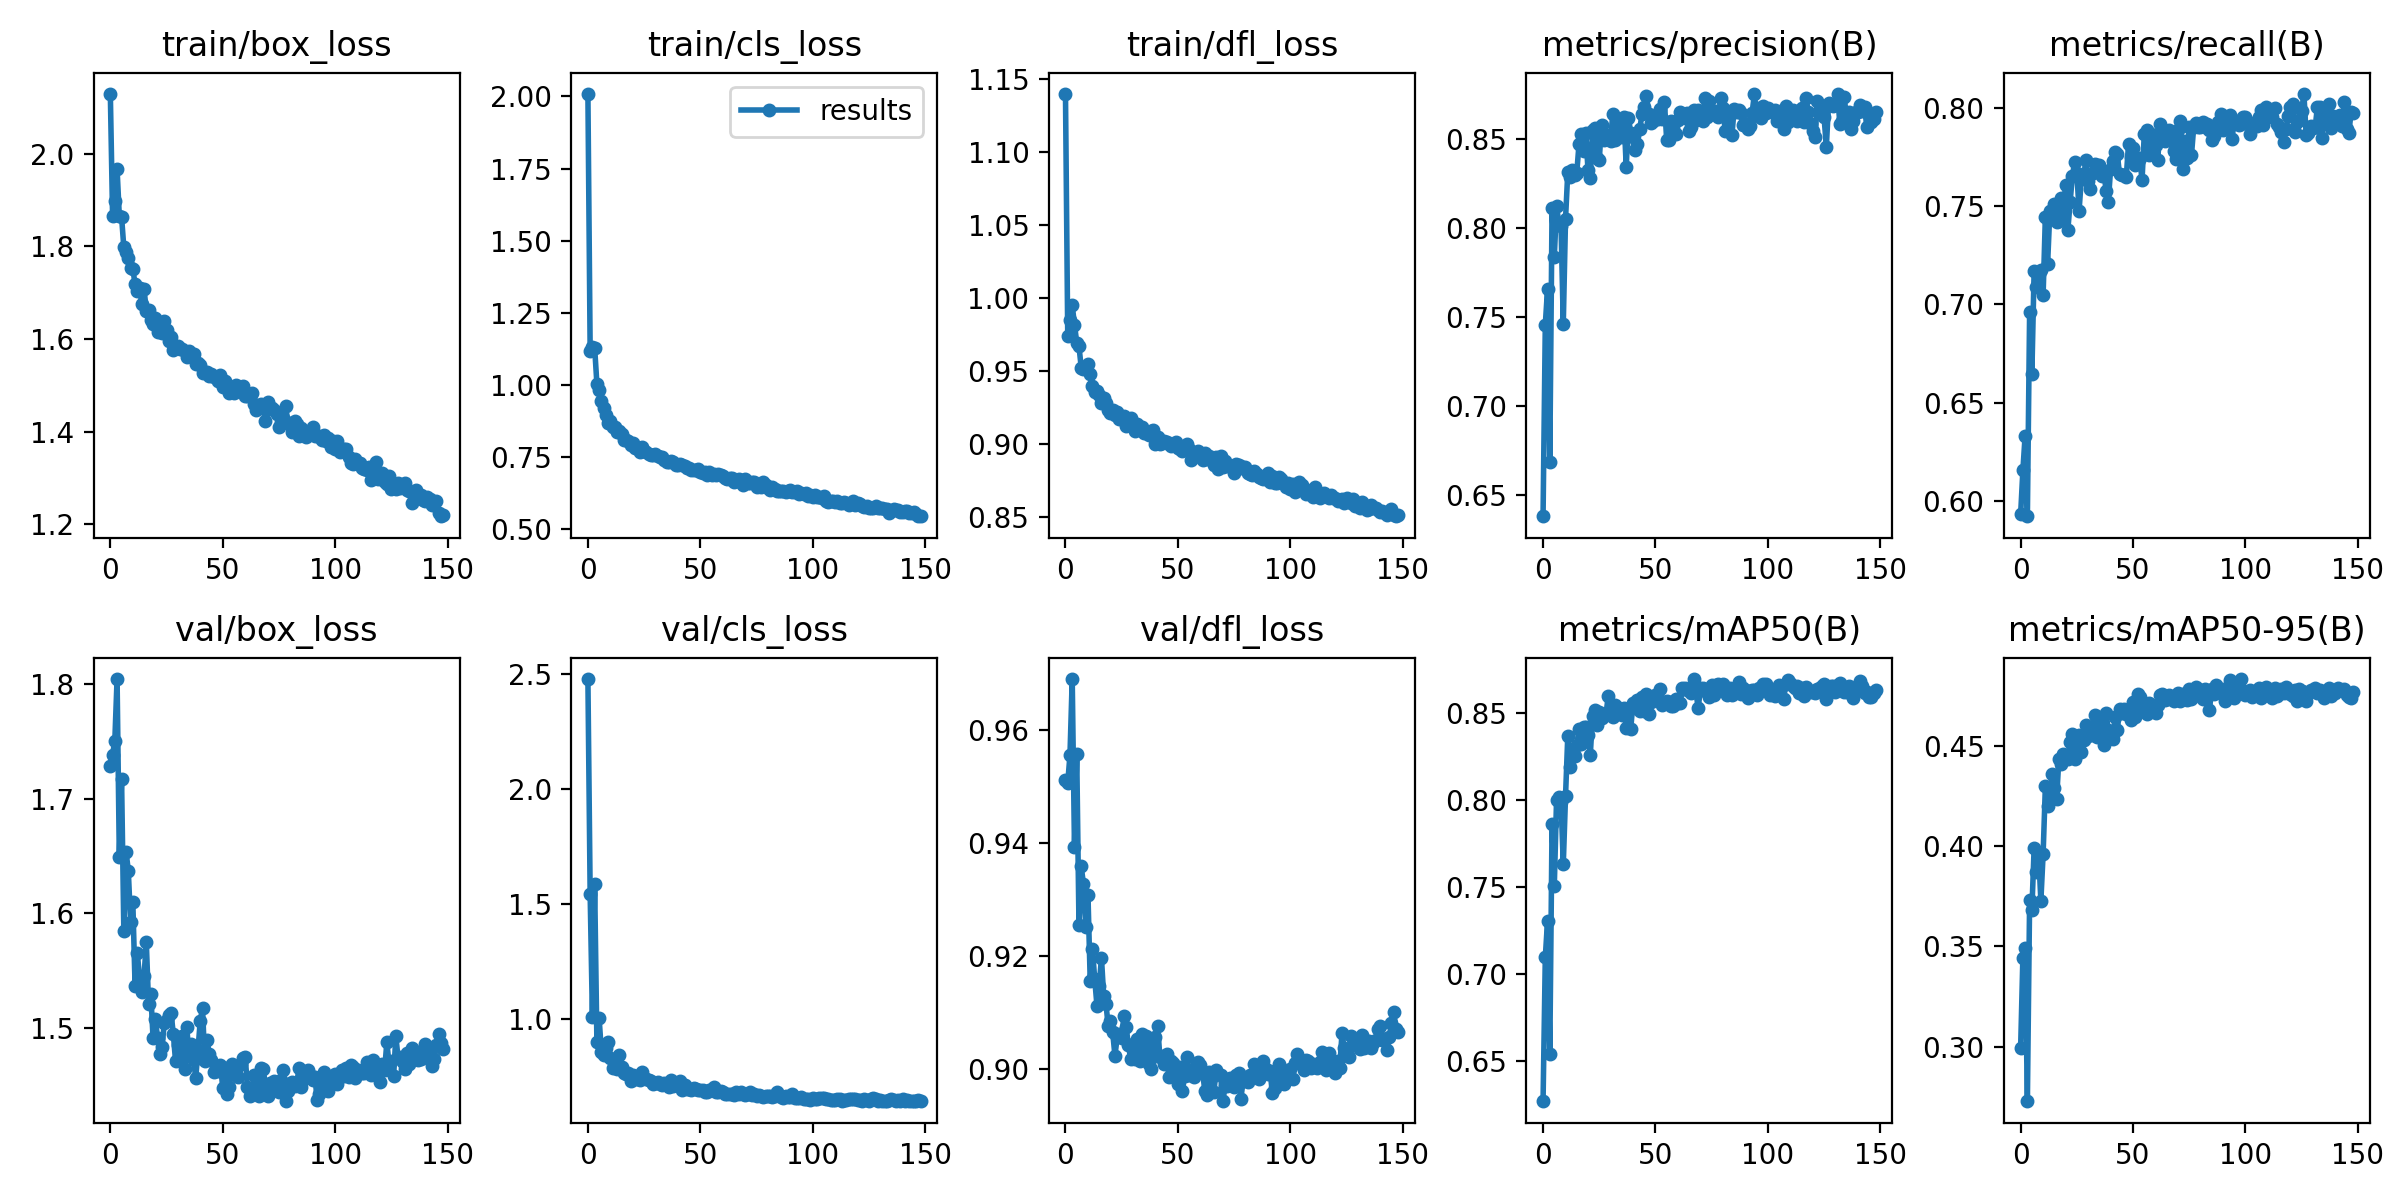

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train6/results.png', width=700)  # display training result

## Validate the Model

The performance on the validation set is close to that on the training set. It seems there is no overfitting, and the model converges well.

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train6/weights/best.pt data={dataset.location}/data.yaml

/content
2023-08-02 01:28:10.056450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 01:28:10.972801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/MinneApple-1/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100% 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:19<00:00,  1.52s/it]
                   all        200       7992      0.867      0.793      0.866      0.484
Speed: 0.9ms pre-process, 7.4ms infer

## Inference with the Model

### Produce detection results

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train6/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
2023-08-02 01:29:41.699686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 01:29:42.633886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
image 1/100 /content/datasets/MinneApple-1/test/images/20150919_174151_image121_png_jpg.rf.b7fc2478313627f87bcbeb831933faf2.jpg: 736x416 116 apples, 72.8ms
image 2/100 /content/datasets/MinneApple-1/test/images/20150919_174151_image161_png_jpg.rf.5e7093b1eab8189a7bb39c635604d7d4.jpg: 736x416 127 apples, 13.7ms
image 3/100 /content/datasets/MinneApple-1/test/images/20150919_174151_imag

**NOTE:** Let's take a look at few results.

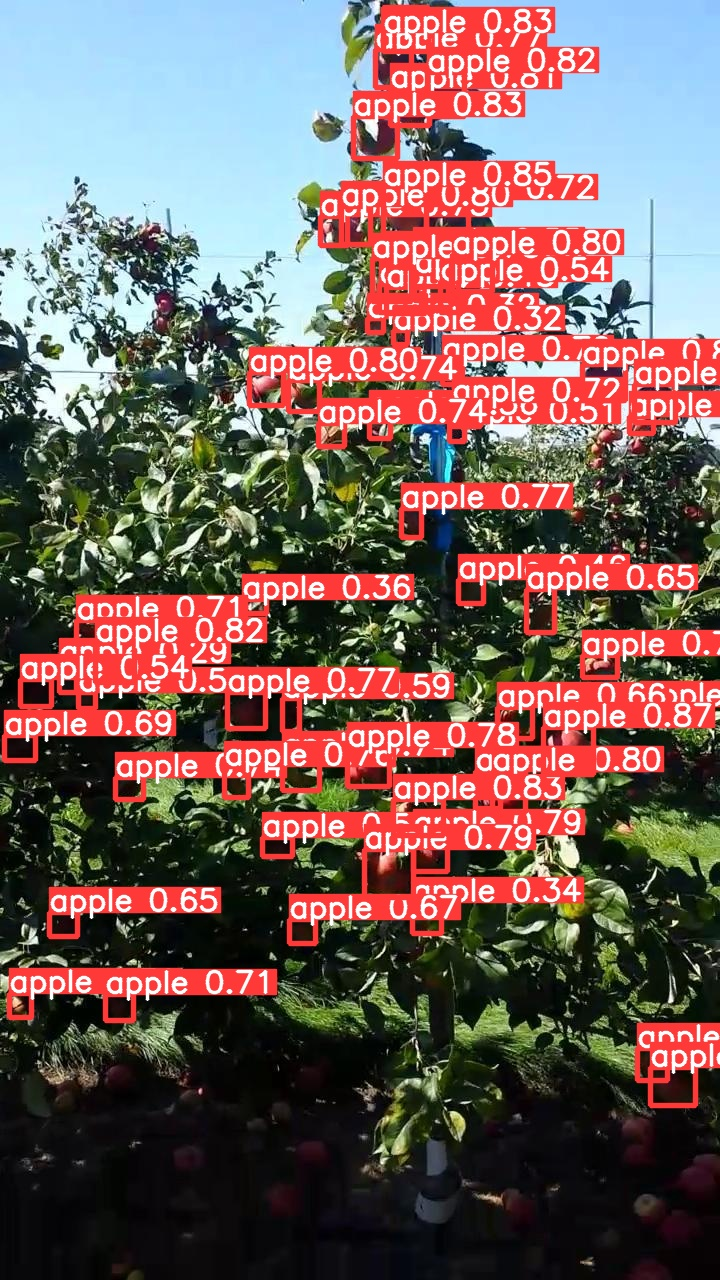

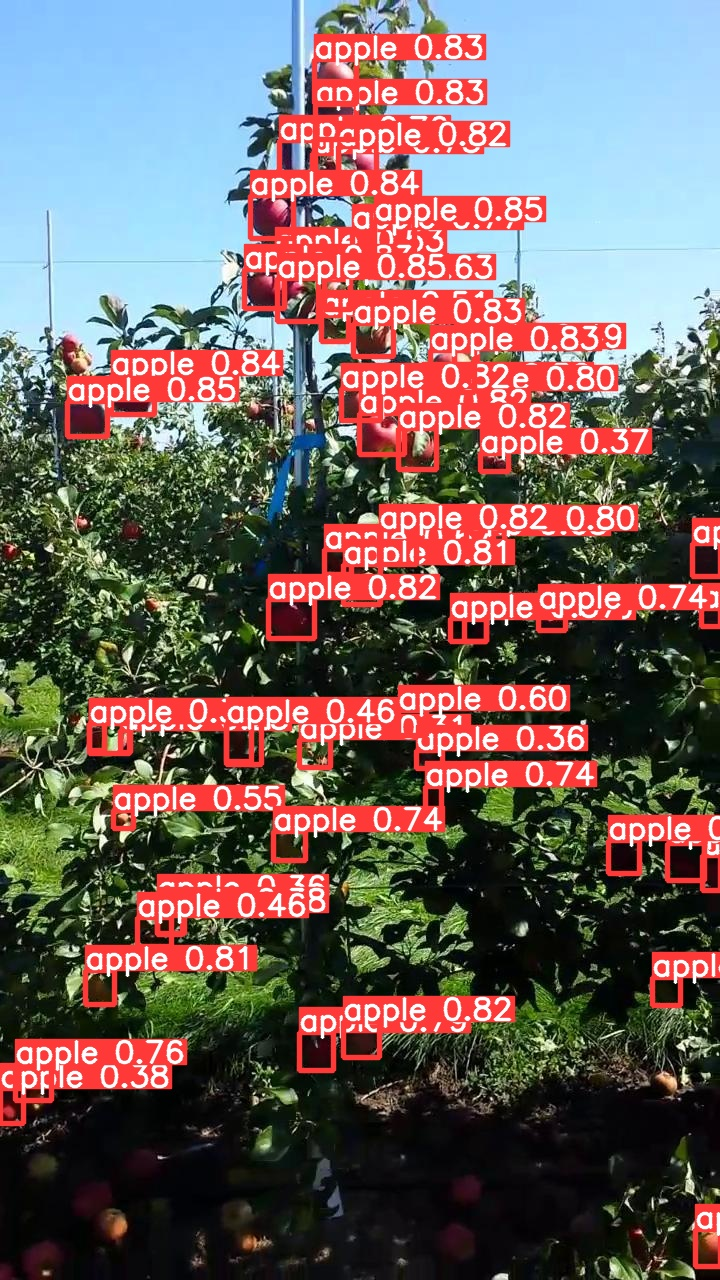

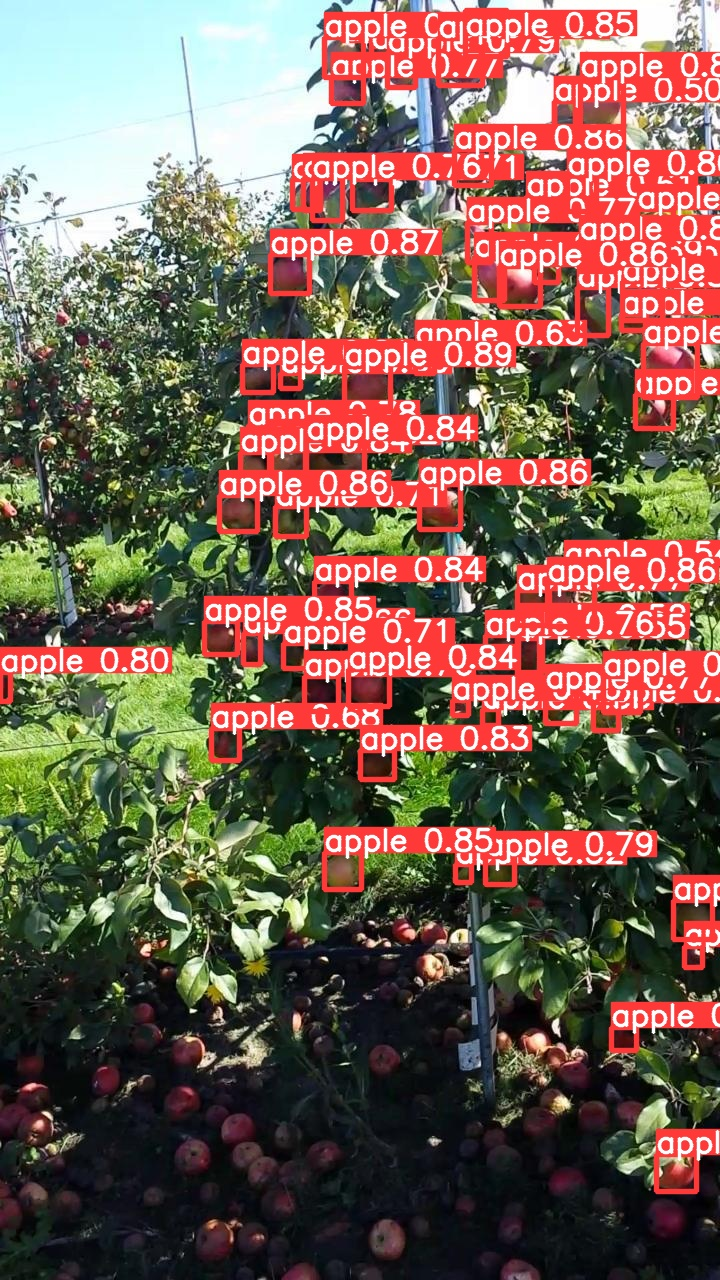

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=300))
      print("\n")

Produce the performance of the model on the test set.

Compared to the training results, the precision and mAP50-95 are close (~0.5%), but the recall is 2.1% higher and the mAP50 is 1.4% higher.

### Evaluate the model on test set


In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train6/weights/best.pt data={dataset.location}/data_test.yaml

/content
2023-08-02 01:30:31.382704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 01:30:32.292964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/MinneApple-1/test/labels... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<00:00, 1316.40it/s]
val: New cache created: /content/datasets/MinneApple-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:18<00:00,  2.61s/it]
                   all        100       3943      0.

# Train on the augmented dataset

## Download the augmented dataset
It contains 1.4k training images.

In [7]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="lOVTQ88BgSlHqrup7AYi")
project = rf.workspace("dissertation-bqltf").project("minneapple-qo6jh")
dataset = project.version(4).download("yolov8")

/content/datasets
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.1 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.20, to fix: `pip install ultralytics==8.0.134`


Extracting Dataset Version Zip to MinneApple-4 in yolov8:: 100%|██████████| 3416/3416 [00:01<00:00, 2280.11it/s]


## Train the model

The training ends at 188th epoch as no improvement.

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=400 imgsz=720 plots=True  # 300


/content
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/MinneApple-4/data.yaml, epochs=400, patience=50, batch=16, imgsz=720, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=F

In [ ]:
!ls {HOME}/runs/detect/train7/  # check the model is prodeced

args.yaml					     train_batch0.jpg
events.out.tfevents.1690940317.8043ed8c498b.64244.0  train_batch1.jpg
results.csv					     train_batch2.jpg
results.png					     weights


In [ ]:
%cp {HOME}/runs/detect/train7/weights/best.pt /content/gdrive/My\ Drive/Dissertation/Models
%cp {HOME}/runs/detect/train7/results.png /content/gdrive/My\ Drive/Dissertation/Models
%cp {HOME}/runs/detect/train7/confusion_matrix.png /content/gdrive/My\ Drive/Dissertation/Models
%cp {HOME}/runs/detect/train7/val_batch0_pred.jpg /content/gdrive/My\ Drive/Dissertation/Models


cp: cannot stat '/content/runs/detect/train7/confusion_matrix.png': No such file or directory
cp: cannot stat '/content/runs/detect/train7/val_batch0_pred.jpg': No such file or directory


/content


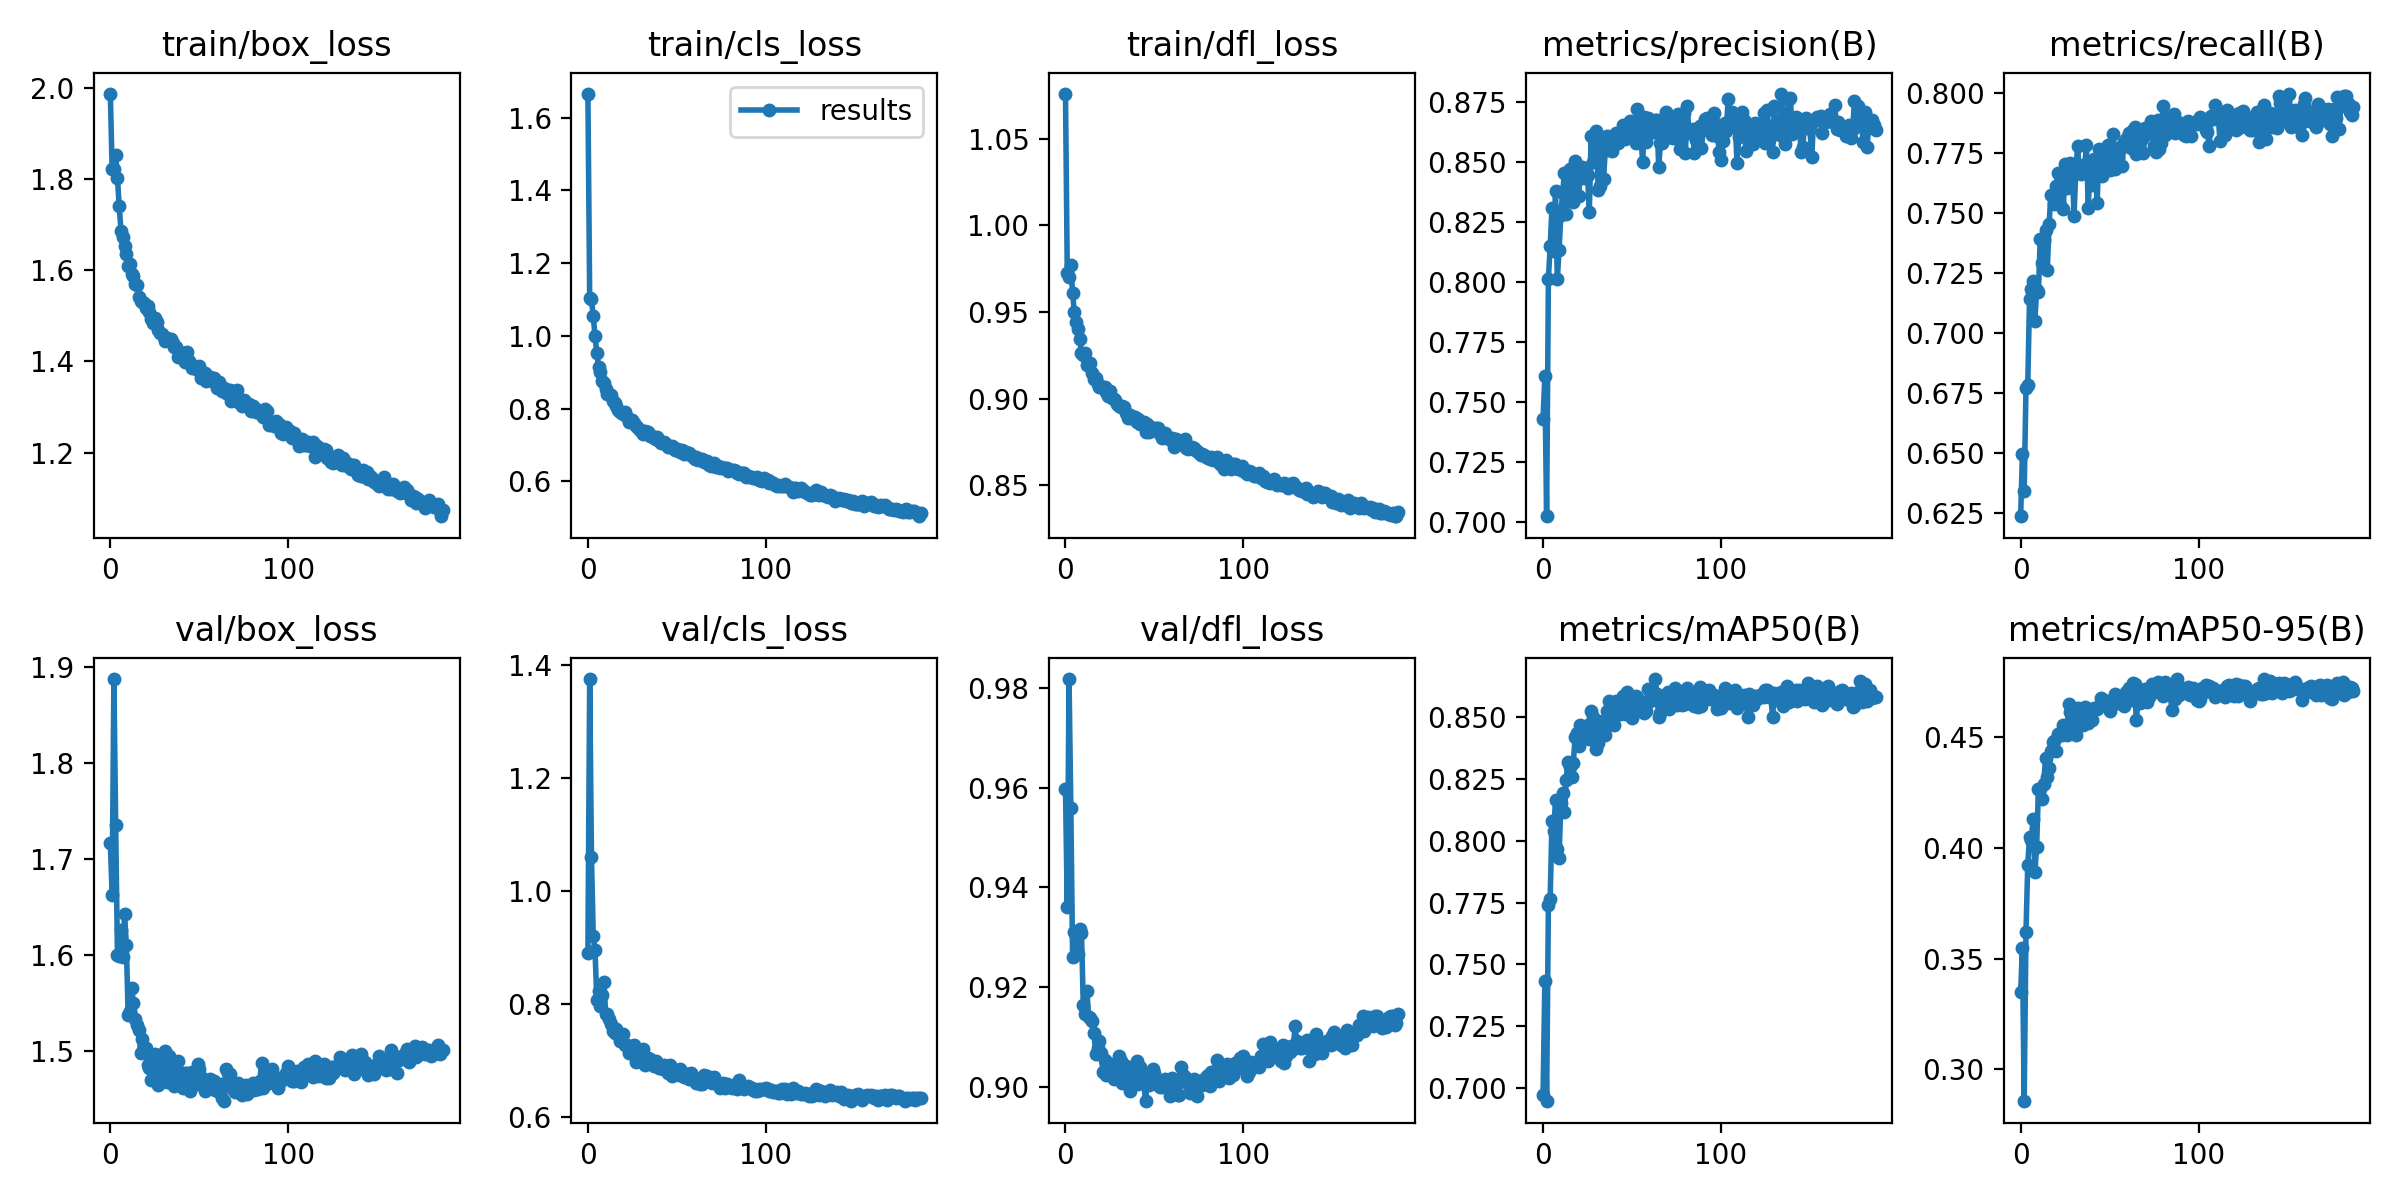

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train7/results.png', width=700)

## Validate the Model

The performance on the validation set is close to that on the training set. It seems there is no overfitting, and the model converge well.

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/gdrive/My\ Drive/Dissertation/Models/aug_best.pt data={dataset.location}/data.yaml

/content
2023-08-02 12:13:54.956594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 12:13:55.850565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/MinneApple-4/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100% 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:18<00:00,  1.45s/it]
                   all        200       7992      0.867      0.796      0.864      0.477
Speed: 0.6ms pre-process, 7.7ms infer

## Inference with the Model

### Produce detection results

In [8]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/gdrive/My\ Drive/Dissertation/Models/aug_best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
2023-08-02 15:25:00.413564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 15:25:01.257625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
image 1/100 /content/datasets/MinneApple-4/test/images/20150919_174151_image121_png_jpg.rf.b7fc2478313627f87bcbeb831933faf2.jpg: 736x416 111 apples, 66.6ms
image 2/100 /content/datasets/MinneApple-4/test/images/20150919_174151_image161_png_jpg.rf.5e7093b1eab8189a7bb39c635604d7d4.jpg: 736x416 124 apples, 13.7ms
image 3/100 /content/datasets/MinneApple-4/test/images/20150919_174

**NOTE:** Let's take a look at few results.

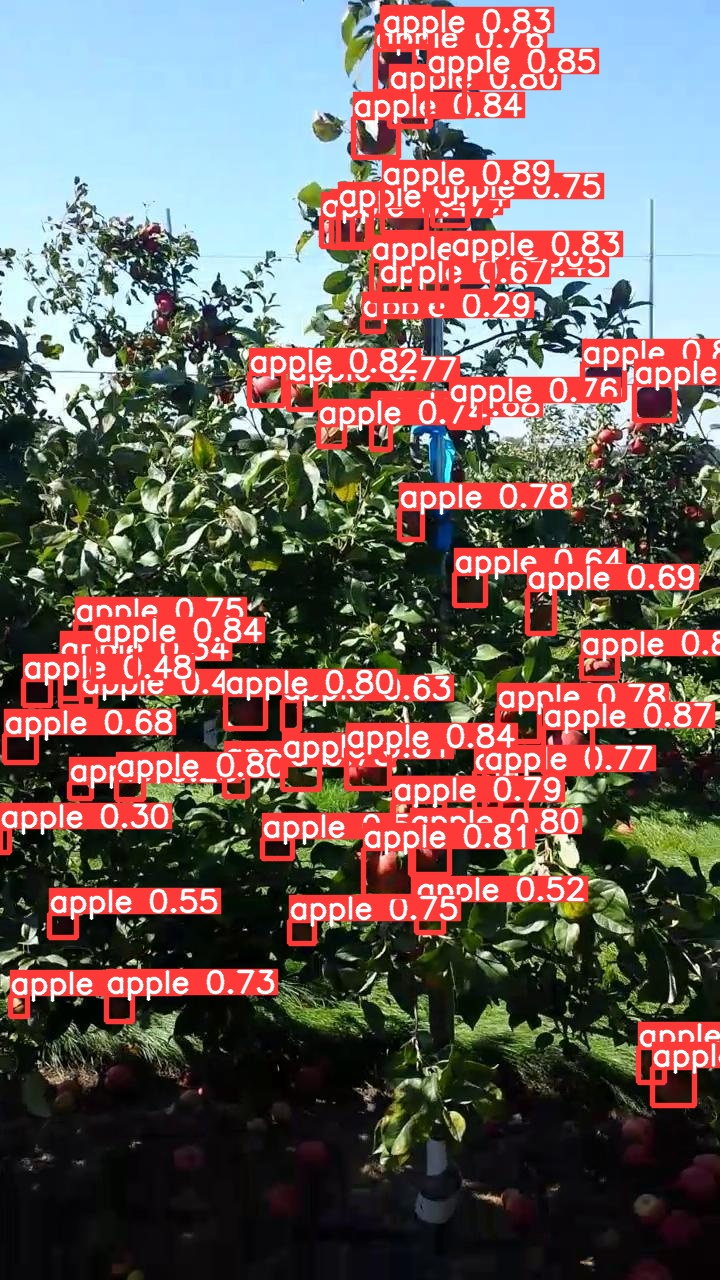

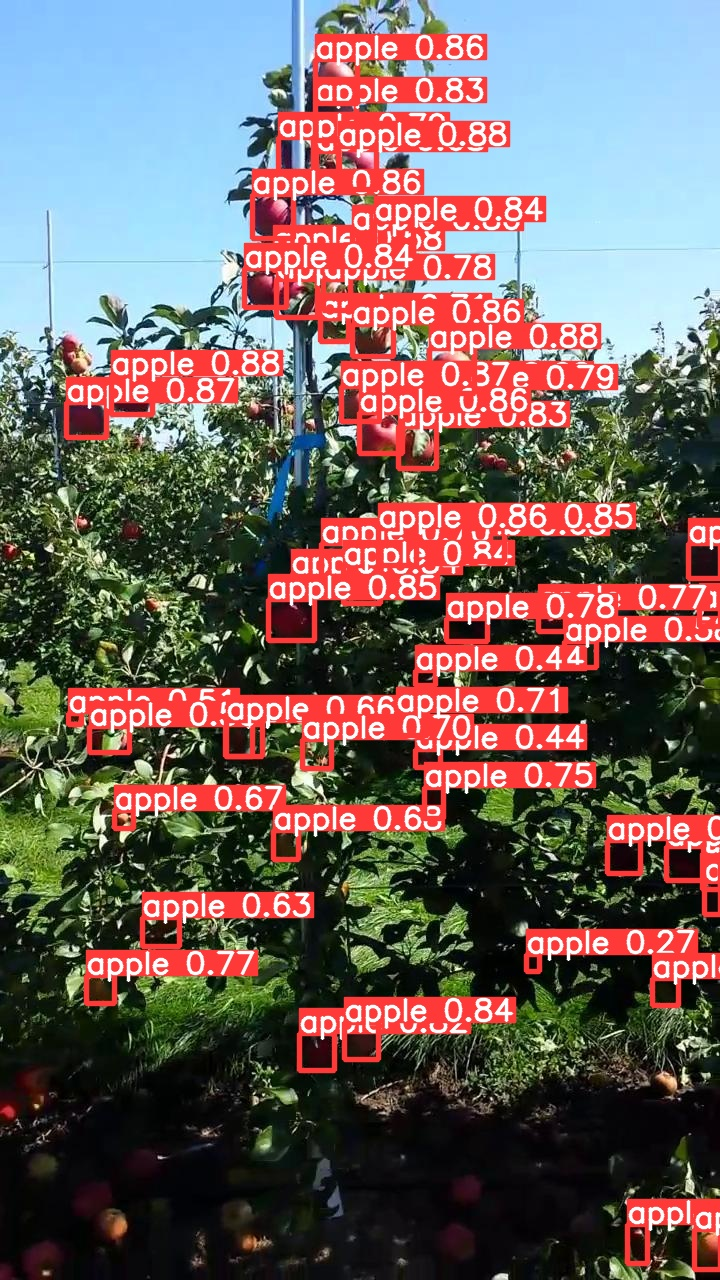

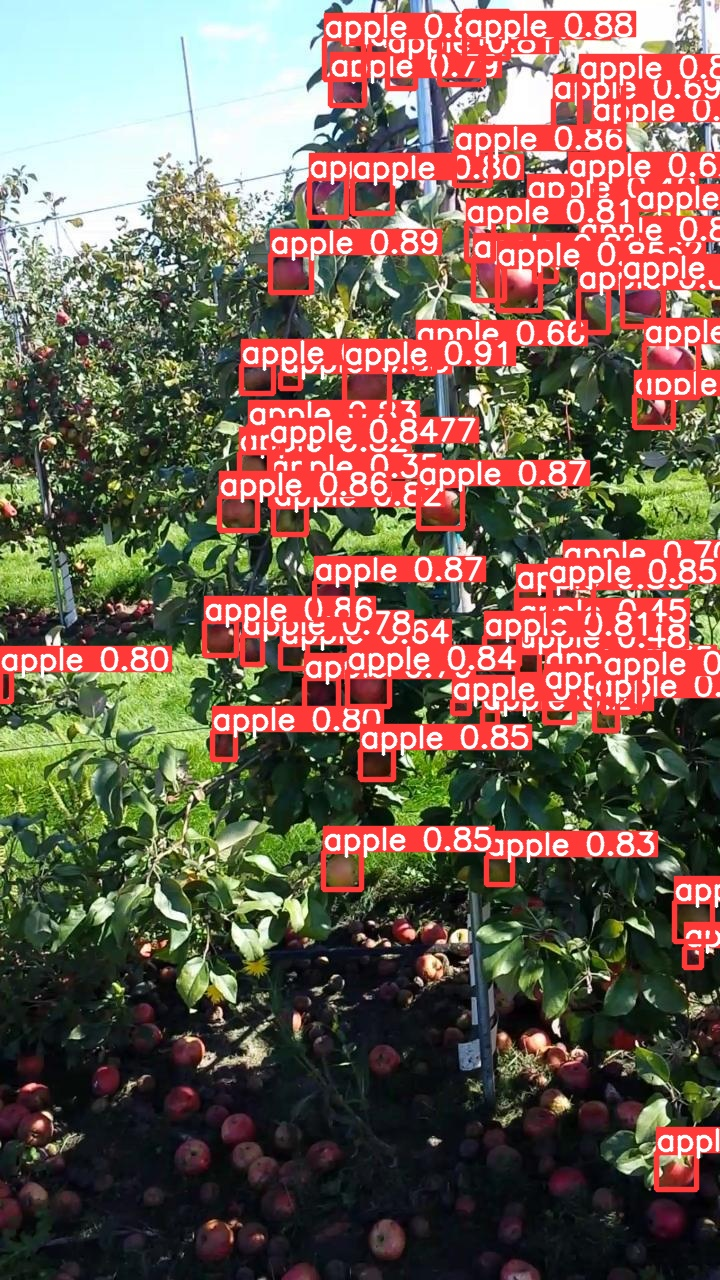

In [9]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=300))
      print("\n")

### Evaluate the model on test set
Produce the performance of the model on the test set.

All other metrics are much higher than the training and validating reaults

In [10]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/gdrive/My\ Drive/Dissertation/Models/aug_best.pt data={dataset.location}/data_test_4.yaml

/content
2023-08-02 15:29:36.236416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 15:29:37.098792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
100% 755k/755k [00:00<00:00, 37.7MB/s]
val: Scanning /content/datasets/MinneApple-4/test/labels... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<00:00, 1291.58it/s]
val: New cache created: /content/datasets/MinneApple-4/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:18<00:00,  2.63s/it]
     